# Analisi *diverse dalle predefinite* della circolazione ferroviaria italiana

Questo lavoro è citato nella mia [tesi](https://github.com/MarcoBuster/tesi).

    railway-opendata: scrape and analyze italian railway data
    Copyright (C) 2023 Marco Aceti

    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import csv
import itertools
import pathlib
import pickle
from datetime import datetime, timedelta
from glob import glob

import dask.dataframe as dd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import timple
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from src.analysis.load_data import read_station_csv, read_train_csv
from src.const import RAILWAY_COMPANIES_PALETTE, TIMEZONE, RailwayCompany
from src.scraper.station import Station
from src.scraper.train import Train
from tqdm import tqdm

tmpl = timple.Timple()
tmpl.enable()

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["text.usetex"] = False
matplotlib.rcParams.update({"font.size": 8})

sns.set_theme(font_scale=0.7, style="whitegrid")

In [2]:
PERIOD_TITLE = "2023-03-01 => 2023-08-31"
OUTPUT = pathlib.Path("output/")

# $\text{1.3}\quad \text{Panorama giuridico, politico e legislativo}$

## $\text{1.3.3}\quad \text{Accesso civico generalizzato}$

### Caricamento dei dati

In [3]:
lomb = pd.read_csv("data/Lombardia_2022.csv", decimal=",", index_col=0).dropna()
lomb.head()

,Gennaio,Febbraio,Marzo,Aprile,Maggio,Giugno,Luglio,Agosto,Settembre,Ottobre,Novembre,Dicembre
DIRETTRICI,,,,,,,,,,,,
NOVARA-MILANO-TREVIGLIO (S6),94.3,92.7,91.8,90.4,87.5,79.9,79.6,83.9,84.5,85.6,86.5,85.4
SARONNO-SEREGNO-MILANO-ALBAIRATE (S9),97.6,95.5,95.9,95.4,95.1,92.7,95.7,97.1,94.7,95.7,92.7,95.5
DOMODOSSOLA-GALLARATE-MILANO,85.8,87.2,83.0,81.5,83.5,87.3,85.1,92.0,87.6,84.6,84.5,85.6
PORTO CERESIO-VARESE-GALLARATE-MILANO,88.4,85.6,83.8,78.8,76.4,76.1,73.8,88.4,82.8,78.4,81.7,81.1
LUINO-GALLARATE-MILANO,91.7,83.4,87.4,89.7,86.1,84.6,88.4,92.0,87.4,86.3,83.4,84.7


In [4]:
lomb.mean(axis=1).sort_values(ascending=False)

DIRETTRICI
MALPENSA-VARESE-MENDRISIO-COMO               98.266667
MALPENSA-MILANO                              96.483333
BERGAMO-TREVIGLIO                            96.208333
CHIAVENNA-COLICO                             95.341667
SARONNO-SEREGNO-MILANO-ALBAIRATE (S9)        95.300000
SARONNO-MILANO-LODI (S1, S3)                 91.925000
BRESCIA-ISEO-EDOLO                           91.866667
PAVIA-MORTARA-VERCELLI                       90.375000
LECCO-CARNATE-MILANO (S8)                    88.850000
MORTARA-NOVARA                               88.166667
MARIANO/CAMNAGO-SEVESO-MILANO (S2, S4)       88.100000
LECCO-MOLTENO-MONZA-MILANO                   87.400000
LUINO-GALLARATE-MILANO                       87.091667
NOVARA-MILANO-TREVIGLIO (S6)                 86.841667
CHIASSO-COMO-MONZA-MILANO (S10 + S11 + R)    86.825000
TREVIGLIO-MILANO PASSANTE-VARESE (S5)        85.916667
NOVARA-SARONNO-MILANO                        85.808333
BRESCIA-CREMONA                              85.725000

In [5]:
lomb.mean(axis=1).std()

7.072583332683383

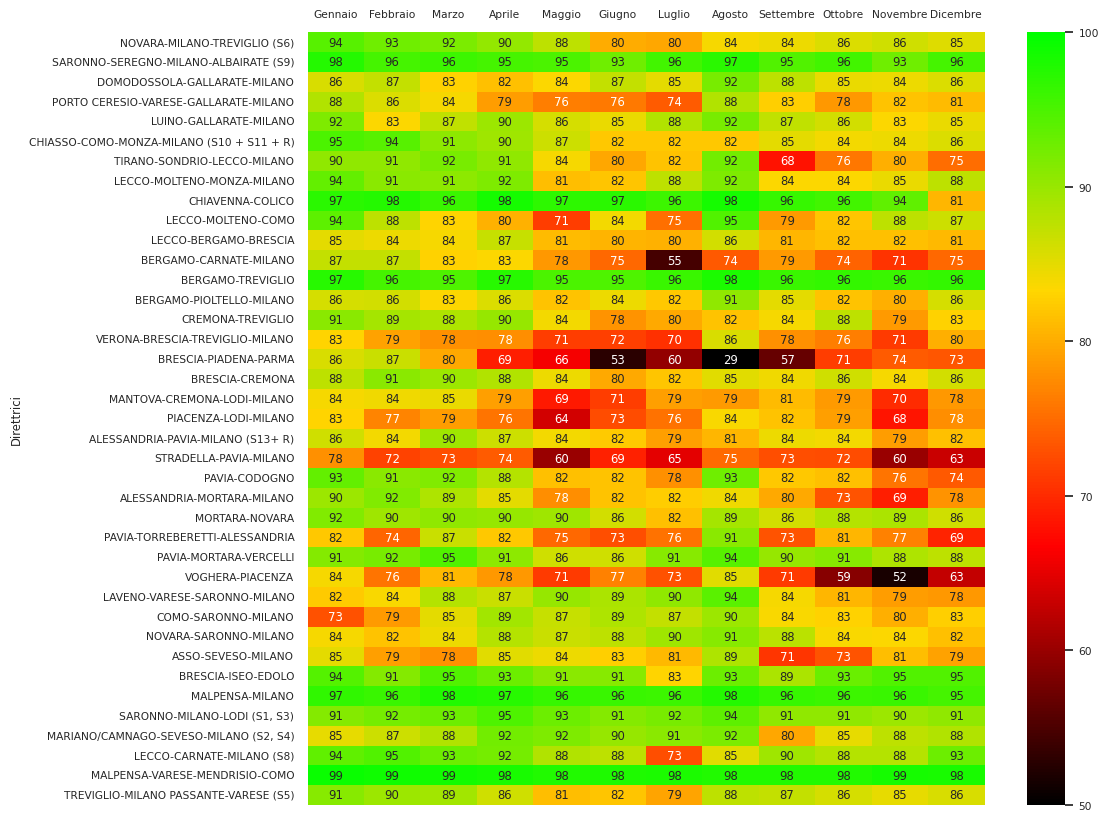

In [6]:
from matplotlib.colors import LinearSegmentedColormap

sns.heatmap(
    lomb,
    # cmap=sns.color_palette("rocket_r", as_cmap=True),
    cmap=LinearSegmentedColormap.from_list(
        "RedGreen", ["black", "red", "gold", "lime"]
    ),
    annot=True,
    robust=True,
    square=False,
    vmin=50,
    vmax=100,
)
fig = plt.gcf()
fig.set_size_inches(11.69, 8.27)  # A4 paper

plt.ylabel("Direttrici")
plt.yticks(np.arange(len(lomb)) + 0.5, list(lomb.index))
plt.xticks(np.arange(len(lomb.columns)) + 0.5, lomb.columns, rotation=0)
ax = plt.gca()
ax.xaxis.set_ticks_position("top")
ax.xaxis.set_tick_params(width=0)
plt.tight_layout()

plt.savefig(OUTPUT / "lomb_heatmap.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

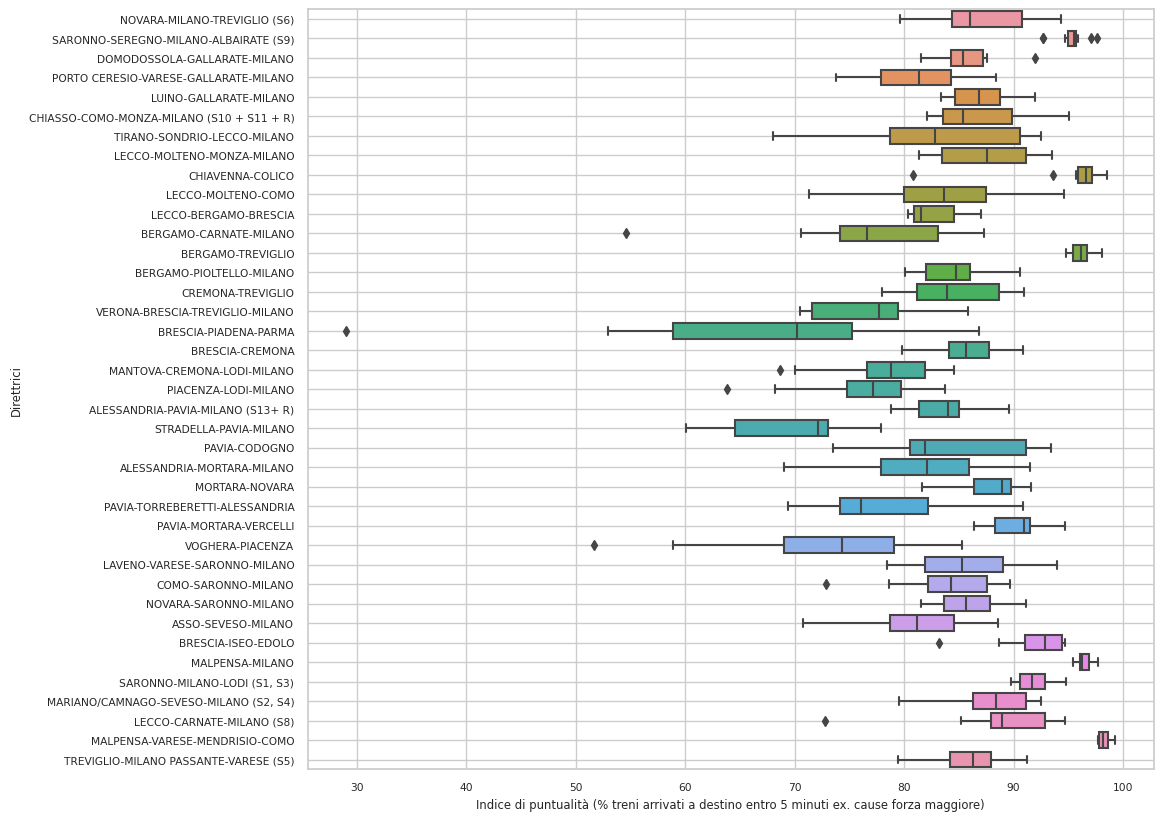

In [7]:
sns.boxplot(lomb.T, orient="h")

fig = plt.gcf()
fig.set_size_inches(11.69, 8.27)  # A4 paper

plt.ylabel("Direttrici")
plt.xlabel(
    "Indice di puntualità (% treni arrivati a destino entro 5 minuti ex. cause forza maggiore)"
)
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()

plt.savefig(OUTPUT / "lomb_boxplot.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

# $\text{3.1}\quad \text{Statistiche predefinite}$

# Lettura dei dati e *tagging*

In [8]:
ddf = dd.read_csv(  # type: ignore
    glob("data/2023-0[45678]-*/trains.csv"),
    dtype={"platform": "str", "arrival_actual": "object", "departure_actual": "object"},
)  # type: ignore

ddf = ddf.loc[(ddf["phantom"] == False) & (ddf["trenord_phantom"] == False)]

ddf.day = dd.to_datetime(ddf.day)
ddf.client_code = ddf.client_code.apply(
    RailwayCompany.from_code, meta=("client_code", "object")
)

ddf = ddf.persist()
ddf.head()

,train_hash,number,day,origin,destination,category,client_code,phantom,trenord_phantom,cancelled,...,stop_station_code,stop_type,platform,arrival_expected,arrival_actual,arrival_delay,departure_expected,departure_actual,departure_delay,crowding
0,a60b3920600b4e70cef7477ca49584af,5894,2023-07-15,S09311,S08217,REG,TRENITALIA_REG,False,False,True,...,S09311,P,2,NaN,NaN,NaN,2023-07-15T05:20:00+02:00,NaN,NaN,NaN
1,a60b3920600b4e70cef7477ca49584af,5894,2023-07-15,S09311,S08217,REG,TRENITALIA_REG,False,False,True,...,S09326,F,NaN,2023-07-15T05:42:00+02:00,NaN,NaN,2023-07-15T05:43:00+02:00,NaN,NaN,NaN
2,a60b3920600b4e70cef7477ca49584af,5894,2023-07-15,S09311,S08217,REG,TRENITALIA_REG,False,False,True,...,S09211,F,NaN,2023-07-15T06:07:00+02:00,NaN,NaN,2023-07-15T06:09:00+02:00,NaN,NaN,NaN
3,a60b3920600b4e70cef7477ca49584af,5894,2023-07-15,S09311,S08217,REG,TRENITALIA_REG,False,False,True,...,S09301,F,NaN,2023-07-15T06:16:00+02:00,NaN,NaN,2023-07-15T06:17:00+02:00,NaN,NaN,NaN
4,a60b3920600b4e70cef7477ca49584af,5894,2023-07-15,S09311,S08217,REG,TRENITALIA_REG,False,False,True,...,S09003,F,NaN,2023-07-15T06:34:00+02:00,NaN,NaN,2023-07-15T06:36:00+02:00,NaN,NaN,NaN


In [9]:
# Escludi ritardi/anticipi estremi
epsilon = 0.01  # quantile

delays = ddf[["arrival_delay", "departure_delay"]].compute()
ylim = [
    min(np.floor(delays.quantile(epsilon))),
    max(np.ceil(delays.quantile(1 - epsilon))),
]
delays = delays.loc[
    (delays.arrival_delay <= ylim[1])
    & (delays.arrival_delay >= ylim[0])
    & (delays.departure_delay <= ylim[1])
    & (delays.departure_delay >= ylim[0]),
]
delays.describe()

,arrival_delay,departure_delay
count,8.723054e+06,8.723054e+06
mean,2.445655e+00,3.648067e+00
std,4.486255e+00,4.468062e+00
min,-5.000000e+00,-5.000000e+00
25%,0.000000e+00,1.000000e+00
50%,1.500000e+00,2.333333e+00
75%,3.500000e+00,4.500000e+00
max,3.400000e+01,3.400000e+01


In [10]:
st = read_station_csv(pathlib.Path("data/stations.csv"))
st.head()

,region,long_name,short_name,latitude,longitude
code,,,,,
S01427,1,Ardenno Masino,Ardenno Masino,46.161980,9.651374
S01947,1,Arena Po,Arena Po,45.082065,9.360394
S01847,1,Asola,Asola,45.220454,10.402313
S01041,1,Corbetta S. Stefano,Corbetta S.Stef.,45.480829,8.917457
S01424,1,Cosio Traona,Cosio Traona,46.135564,9.525498


## $3.1.1\quad \texttt{describe}$

### (A) Quante volte il ritardo in arrivo è \< del ritardo in partenza?

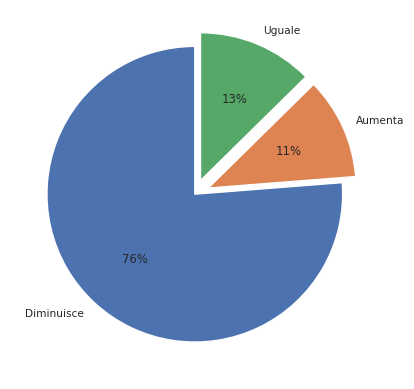

In [11]:
delays_nona = delays.dropna()

less = len(
    delays_nona.loc[delays_nona["arrival_delay"] < delays_nona["departure_delay"]]
) / len(delays_nona)
less_or_eq = len(
    delays_nona.loc[delays_nona["arrival_delay"] <= delays_nona["departure_delay"]]
) / len(delays_nona)

del delays_nona

plt.pie(
    [less, 1 - less_or_eq, less_or_eq - less],
    labels=["Diminuisce", "Aumenta", "Uguale"],
    startangle=90,
    autopct=lambda pct: f"{round(pct)}%",
    explode=(0, 0.1, 0.1),
)
# plt.title("Variazione del ritardo tra l'arrivo e la partenza in una fermata")
plt.savefig(OUTPUT / "delay_var.pdf", bbox_inches="tight")
plt.show()

### (B) Probabilità affollamento \>= 80

In [12]:
crowding = ddf.groupby("train_hash")["crowding"].mean().compute()
crowding = crowding.loc[(crowding > 0) & (crowding < 100)]
len(crowding.loc[crowding >= 80]) / len(crowding) * 100

1.8346232095938169

## $3.1.2\quad \texttt{delay\_boxplot}$

### (C) Confronto mediana imprese ferroviarie

In [13]:
ddf.groupby("client_code")[["arrival_delay", "departure_delay"]].median().compute()

,arrival_delay,departure_delay
client_code,,
TRENORD,1.5,2.5
TRENITALIA_IC,3.0,4.5
TPER,1.5,2.0
OBB,4.0,4.5
OTHER,7.5,3.0
TRENITALIA_REG,1.0,2.0
TRENITALIA_AV,2.5,3.5


## $3.1.3\quad \texttt{day\_train\_count}$

### (D) Numero di treni medi per giornata

In [14]:
day_train_count = (
    ddf.loc[
        (ddf.day >= datetime(year=2023, month=4, day=1))
        & (ddf.day <= datetime(year=2023, month=4, day=30))
    ]
    .groupby("day")
    .train_hash.nunique()
    .compute()
)
day_train_count.describe()

count      30.000000
mean     7697.300000
std      1793.894437
min      2773.000000
25%      6835.000000
50%      8833.500000
75%      9065.750000
max      9141.000000
Name: train_hash, dtype: float64

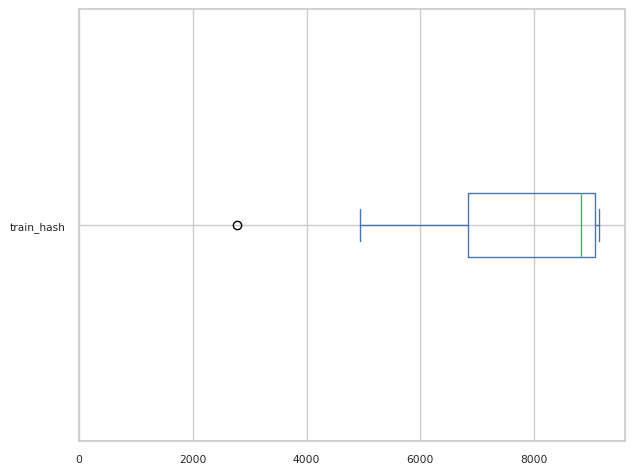

In [15]:
day_train_count.plot.box(vert=False)
plt.tight_layout()
plt.xlim(0, max(day_train_count) * 1.05)
plt.show()

# $3.2\quad\text{Altre statistiche}$

## $\text{3.2.1}\quad \text{Ritardo come variabile aleatoria}$

### (E) Istogramma ritardi

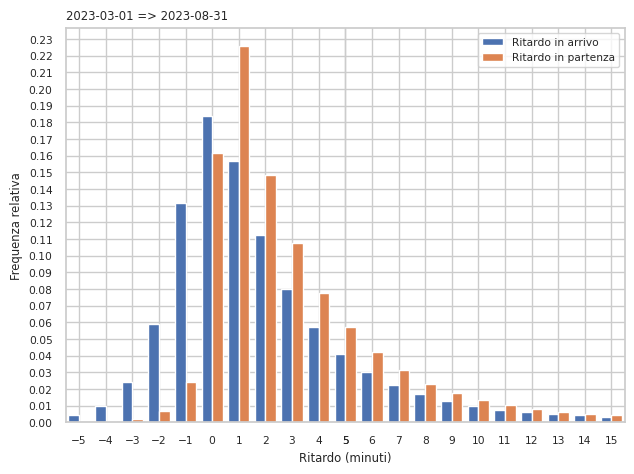

In [16]:
xlim = (-5, 15)

plt.hist(
    (delays.arrival_delay, delays.departure_delay),
    bins=int(max(delays.max()) - min(delays.min())),
    density=True,
    align="left",
    alpha=1,
)

plt.xlim(xlim[0] - 0.5, xlim[1] + 0.5)
plt.xticks([*range(xlim[0], xlim[1] + 1, 1), 5])
plt.yticks(np.arange(0, 0.24, 0.01))

plt.legend(["Ritardo in arrivo", "Ritardo in partenza"])
plt.title(PERIOD_TITLE, loc="left")
plt.ylabel("Frequenza relativa")
plt.xlabel("Ritardo (minuti)")
plt.tight_layout()

plt.savefig(OUTPUT / "delay_hist.pdf")
plt.show()

### (F) CDF ritardi

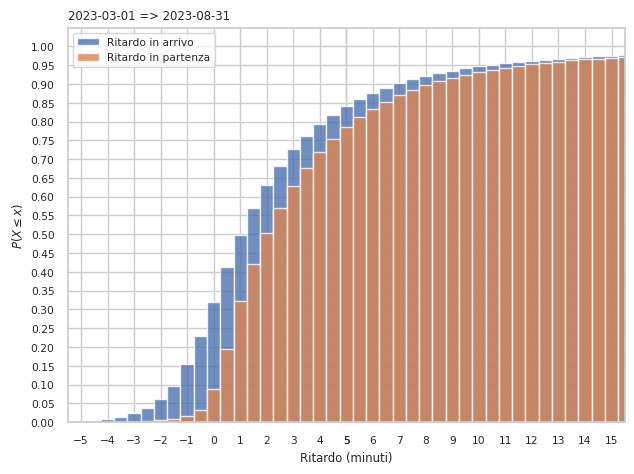

In [17]:
delays.plot.hist(
    bins=int(max(delays.max()) - min(delays.min())) * 2,
    cumulative=True,
    density=True,
    align="left",
    alpha=0.8,
)

plt.xlim(xlim[0] - 0.5, xlim[1] + 0.5)
plt.xticks([*range(xlim[0], xlim[1] + 1), 5])
plt.yticks(np.arange(0, 1.05, 0.05))

plt.legend(["Ritardo in arrivo", "Ritardo in partenza"])
plt.title(PERIOD_TITLE, loc="left")
plt.ylabel("$P(X \leq x)$")
plt.xlabel("Ritardo (minuti)")
plt.tight_layout()

plt.savefig(OUTPUT / "delay_hist_acc.pdf")
plt.show()

### (G) % di treni arrivati entro tot minuti

In [18]:
for i in [3, 5, 10, 15]:
    f_i = len(delays.loc[delays.arrival_delay <= i]) / len(delays)
    print(
        f"Treni arrivati in fermata con <= {i:2} minuti di ritardo: {f_i*100:.2f}% (rimanente: {(1-f_i)*100:.2f}%)"
    )

Treni arrivati in fermata con <=  3 minuti di ritardo: 72.20% (rimanente: 27.80%)
Treni arrivati in fermata con <=  5 minuti di ritardo: 83.94% (rimanente: 16.06%)
Treni arrivati in fermata con <= 10 minuti di ritardo: 94.63% (rimanente: 5.37%)
Treni arrivati in fermata con <= 15 minuti di ritardo: 97.54% (rimanente: 2.46%)


## $\text{3.2.2}\quad\text{Andamento infragiornaliero}$

### (H) Andamento infragiornaliero

In [19]:
# Configuration

# Period size (in seconds)
PERIOD = 5 * 60

# Minimum number of trains in a timeframe
LIMIT = 100

In [20]:
trains = ddf.groupby("train_hash")
train_data = dd.from_pandas(pd.DataFrame(), npartitions=16)
train_data.set_index(ddf.train_hash.unique())

train_data["day"] = trains.first()["day"]
train_data["departure"] = dd.to_datetime(
    trains.first()["departure_actual"].fillna(trains.first()["departure_expected"]),
    utc=True,
    errors="coerce",
)
train_data["arrival"] = dd.to_datetime(
    trains.last()["arrival_actual"].fillna(trains.last()["arrival_expected"]),
    utc=True,
    errors="coerce",
)
train_data["departure_delay"] = trains.mean(numeric_only=True)["departure_delay"]
train_data["arrival_delay"] = trains.mean(numeric_only=True)["arrival_delay"]

train_data = train_data.repartition(npartitions=16).persist()

# Convert dates to hour/minute/second
train_data.departure -= dd.to_datetime(train_data.departure.dt.date, utc=True)
train_data.arrival -= dd.to_datetime(train_data.arrival.dt.date, utc=True)

train_data = train_data.compute()
train_data.head()

,day,departure,arrival,departure_delay,arrival_delay
train_hash,,,,,
000289de885e4c713820bd27773a21e0,2023-07-15,0 days 16:43:30,0 days 17:34:30,14.142857,15.625000
0004380f26409aa83b9e764facb4de16,2023-07-15,0 days 10:43:00,0 days 12:28:00,11.269231,10.423077
0011d5681080b5a0f14da7c5c7a75594,2023-07-15,0 days 18:35:30,0 days 19:52:30,0.666667,-0.555556
0015bbeb3db3a152b43a9d9d1f4a6ed4,2023-07-15,0 days 04:24:00,0 days 04:52:00,2.500000,0.833333
0016a0e5300c3a62dcdc1603b1ee827b,2023-07-15,0 days 13:48:30,0 days 15:01:30,33.285714,32.357143


In [21]:
times = pd.timedelta_range(
    start=train_data.departure.min(),
    end=train_data.arrival.max(),
    freq=f"{PERIOD}S",
)
times_df = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        (train_data.day.unique(), times), names=["day", "time"]
    ),
    columns=["train_count", "departure_delay", "arrival_delay"],
)
for time in tqdm(times):
    subset = train_data.loc[
        (train_data.departure < time) & (train_data.arrival >= time)
    ]
    subset_grouped = subset.groupby("day")
    for date, group in subset_grouped:
        times_df.at[(date, time), "train_count"] = len(group)
        times_df.at[(date, time), "departure_delay"] = group["departure_delay"].median()
        times_df.at[(date, time), "arrival_delay"] = group["arrival_delay"].median()

times_df["train_count"] = pd.to_numeric(times_df["train_count"])
times_df["arrival_delay"] = pd.to_numeric(times_df["arrival_delay"])
times_df["departure_delay"] = pd.to_numeric(times_df["departure_delay"])
times_df = times_df.dropna()
times_df.head()

100%|██████████| 288/288 [00:27<00:00, 10.47it/s]


train_count  departure_delay  arrival_delay
day        time                                                        
2023-07-15 0 days 01:35:00          1.0        10.625000      14.625000
           0 days 01:40:00          2.0         5.548611       6.951389
           0 days 01:45:00          2.0         5.548611       6.951389
           0 days 01:50:00          2.0         5.548611       6.951389
           0 days 01:55:00          4.0         6.312500       7.653409

In [22]:
times_melted = pd.melt(
    times_df.loc[times_df.train_count > LIMIT].dropna().reset_index(),
    id_vars=["time"],
    value_vars=["train_count", "arrival_delay", "departure_delay"],
)
times_melted.head()

,time,variable,value
0,0 days 03:10:00,train_count,117.0
1,0 days 03:15:00,train_count,134.0
2,0 days 03:20:00,train_count,158.0
3,0 days 03:25:00,train_count,178.0
4,0 days 03:30:00,train_count,207.0


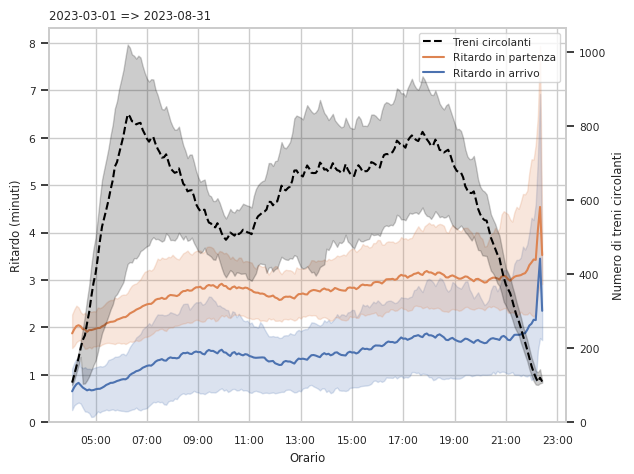

In [23]:
sns.set_theme(style="whitegrid", palette="deep", font_scale=0.7)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M", TIMEZONE))  # type: ignore

lns1 = sns.lineplot(
    data=times_melted.loc[times_melted.variable != "train_count"].reset_index(),
    x="time",
    y="value",
    hue="variable",
    ax=ax,
    # legend="full",
    errorbar="pi",
)
ax.plot(np.nan, color="black", label="train_count")

ax2 = ax.twinx()
lns2 = sns.lineplot(
    data=times_melted.loc[times_melted.variable == "train_count"].reset_index(),
    x="time",
    y="value",
    color="black",
    linestyle="--",
    ax=ax2,
    errorbar="pi",
)

ax.legend(
    [ax2.lines[0], ax.lines[1], ax.lines[0]],
    ["Treni circolanti", "Ritardo in partenza", "Ritardo in arrivo"],
)
plt.title(PERIOD_TITLE, loc="left")
ax.set_xlabel("Orario")
ax.set_ylim(0)
ax.set_ylabel("Ritardo (minuti)")
ax2.set_ylim(0)
ax2.grid(None)
ax2.set_ylabel("Numero di treni circolanti")
plt.tight_layout()

plt.savefig(OUTPUT / "intraday_delay.pdf")
plt.show()

### (I) Metriche infragiornaliere

In [24]:
hours_df = times_df.reset_index().copy()
hours_df["hour"] = (hours_df.time.dt.total_seconds() / 60 // 60).astype(int)

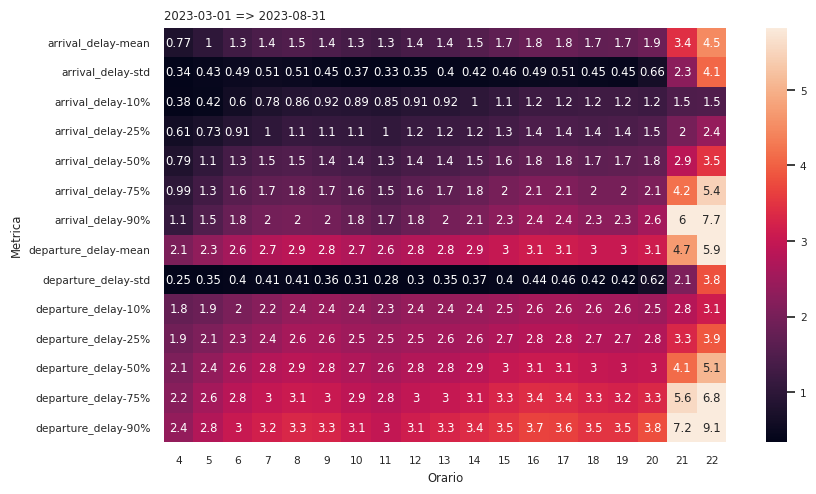

In [25]:
describe = (
    hours_df[["hour", "arrival_delay", "departure_delay"]]
    .loc[(hours_df.hour > 3) & (hours_df.hour < 23)]
    .groupby("hour")
    .describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.9])
    .drop(
        itertools.product(
            [
                "arrival_delay",
                "departure_delay",
            ],
            (
                "count",
                "min",
                "max",
            ),
        ),
        axis=1,
    )
)

fig, ax = plt.subplots(figsize=(9.2, 5))
sns.heatmap(
    describe.T,
    annot=True,
    robust=True,
    square=True,
    ax=ax,
)
plt.xlabel("Orario")
plt.ylabel("Metrica")
plt.title(PERIOD_TITLE, loc="left")
plt.tight_layout()

plt.savefig("output/intraday_metrics.pdf", bbox_inches="tight", pad_inches=0.02)
plt.show()

## $\text{3.2.3}\quad \text{Ritardo relativo}$

### (J) Ritardo relativo dei treni italiani, per impresa ferroviaria

In [26]:
trains = ddf.groupby("train_hash")
train_data_exp = dd.from_pandas(pd.DataFrame(), npartitions=16)
train_data_exp.set_index(ddf.train_hash.unique())

train_data_exp["day"] = trains.first()["day"]
train_data_exp["departure"] = dd.to_datetime(
    trains.first()["departure_expected"],
    utc=True,
    errors="coerce",
)
train_data_exp["arrival"] = dd.to_datetime(
    trains.last()["arrival_expected"],
    utc=True,
    errors="coerce",
)
train_data_exp = train_data_exp.repartition(npartitions=16).compute()
train_data_exp.head()

,day,departure,arrival
train_hash,,,
000289de885e4c713820bd27773a21e0,2023-07-15,2023-07-15 16:40:00+00:00,2023-07-15 17:23:00+00:00
0004380f26409aa83b9e764facb4de16,2023-07-15,2023-07-15 10:42:00+00:00,2023-07-15 12:14:00+00:00
0011d5681080b5a0f14da7c5c7a75594,2023-07-15,2023-07-15 18:35:00+00:00,2023-07-15 19:54:00+00:00
0015bbeb3db3a152b43a9d9d1f4a6ed4,2023-07-15,2023-07-15 04:21:00+00:00,2023-07-15 04:52:00+00:00
0016a0e5300c3a62dcdc1603b1ee827b,2023-07-15,2023-07-15 13:17:00+00:00,2023-07-15 14:31:00+00:00


In [27]:
duration = pd.DataFrame(
    (train_data_exp.arrival - train_data_exp.departure).dt.seconds / 60
).rename({0: "duration"}, axis=1)
duration.head()

,duration
train_hash,
000289de885e4c713820bd27773a21e0,43.0
0004380f26409aa83b9e764facb4de16,92.0
0011d5681080b5a0f14da7c5c7a75594,79.0
0015bbeb3db3a152b43a9d9d1f4a6ed4,31.0
0016a0e5300c3a62dcdc1603b1ee827b,74.0


In [28]:
train_means = (
    ddf.loc[~ddf.client_code.isin(["OBB", "OTHER"])]
    .groupby("train_hash")[["arrival_delay", "departure_delay", "client_code"]]
    .agg(
        {
            "arrival_delay": "median",
            "departure_delay": "median",
            "client_code": "first",
        },
        shuffle="tasks",
    )
    .compute()
    .join(duration)
)

train_means = train_means.loc[train_means.duration > 0]
train_means["arrival_delay_%"] = (
    train_means["arrival_delay"] / train_means["duration"] * 100
)
train_means["departure_delay_%"] = (
    train_means["departure_delay"] / train_means["duration"] * 100
)

train_means.head()

,arrival_delay,departure_delay,client_code,duration,arrival_delay_%,departure_delay_%
train_hash,,,,,,
8fafc39db5fcf0d4beca1d364eb1abb5,0.5,1.00,TRENITALIA_REG,46.0,1.086957,2.173913
9d772e1e50058661c254badf54f49a01,40.0,42.00,TPER,122.0,32.786885,34.426230
66eb7551fe1a9d7309caaf572f0573b8,-2.0,1.00,TRENITALIA_REG,39.0,-5.128205,2.564103
80010548785f25721628d888952ee1bc,-0.5,0.50,TRENITALIA_REG,130.0,-0.384615,0.384615
9f01a4e9c8ff0eaee6b72c5c37c0ff7e,0.5,1.25,TRENITALIA_REG,30.0,1.666667,4.166667


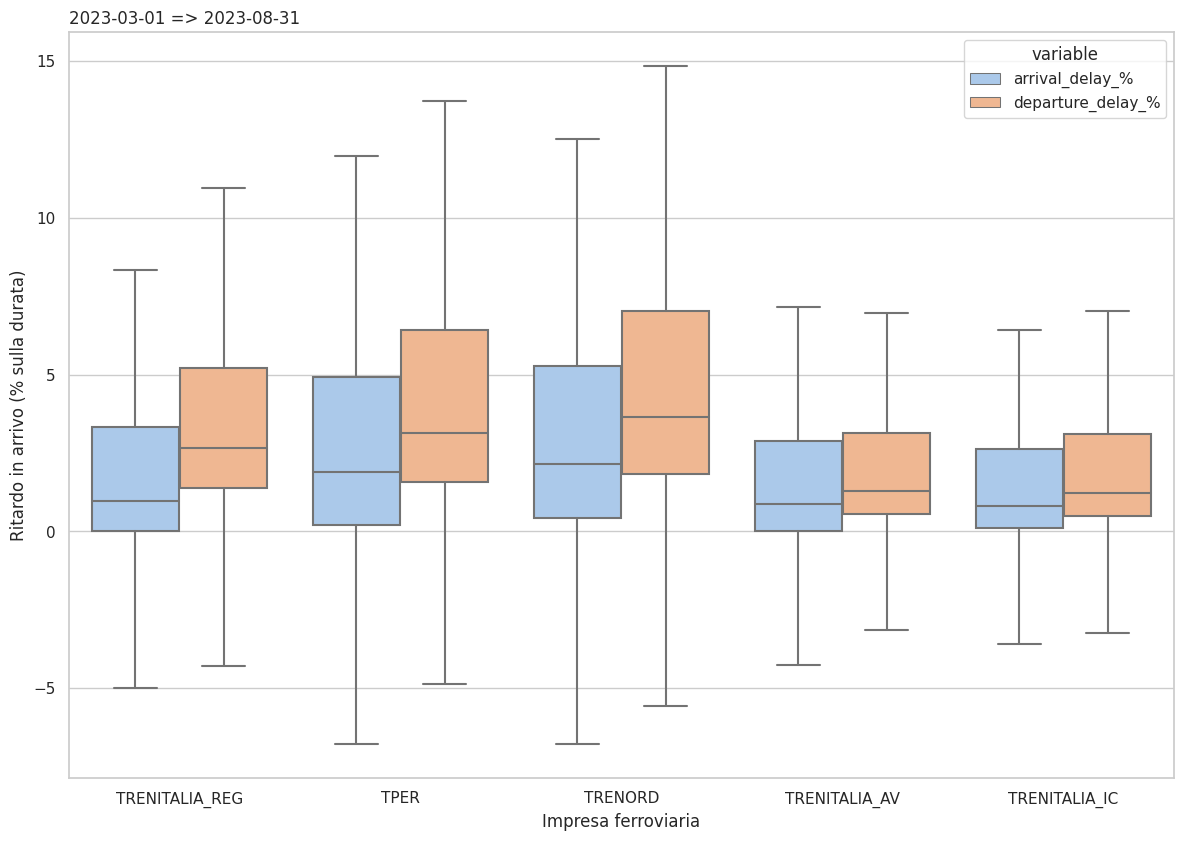

In [29]:
plt.rcParams["figure.figsize"] = (12, 12 * 5 / 7)
sns.set_theme(style="whitegrid", palette="pastel")
sns.boxplot(
    pd.melt(
        train_means[["client_code", "arrival_delay_%", "departure_delay_%"]],
        id_vars=["client_code"],
    ),
    x="client_code",
    y="value",
    hue="variable",
    showfliers=False,
)
plt.title(PERIOD_TITLE, loc="left")
plt.xlabel("Impresa ferroviaria")
plt.ylabel("Ritardo in arrivo (% sulla durata)")

plt.tight_layout()
plt.savefig(OUTPUT / "delay_box_percentage_wd.pdf")
plt.show()

In [30]:
train_means.groupby("client_code")[["arrival_delay_%", "departure_delay_%"]].mean()

,arrival_delay_%,departure_delay_%
client_code,,
TPER,4.037065,5.626456
TRENITALIA_AV,3.013062,3.474620
TRENITALIA_IC,2.900845,3.361145
TRENITALIA_REG,2.703809,4.902292
TRENORD,4.157305,6.169743


### (K) Correlazione tra ritardo mediano assoluto di una corsa e sua durata

In [31]:
ncuts = 51
train_means["duration_cat"] = pd.qcut(
    x=train_means.duration,
    q=ncuts,
    duplicates="drop",
)
category_means = (
    train_means.groupby("duration_cat")
    .mean()[["arrival_delay", "departure_delay"]]
    .reset_index()
)

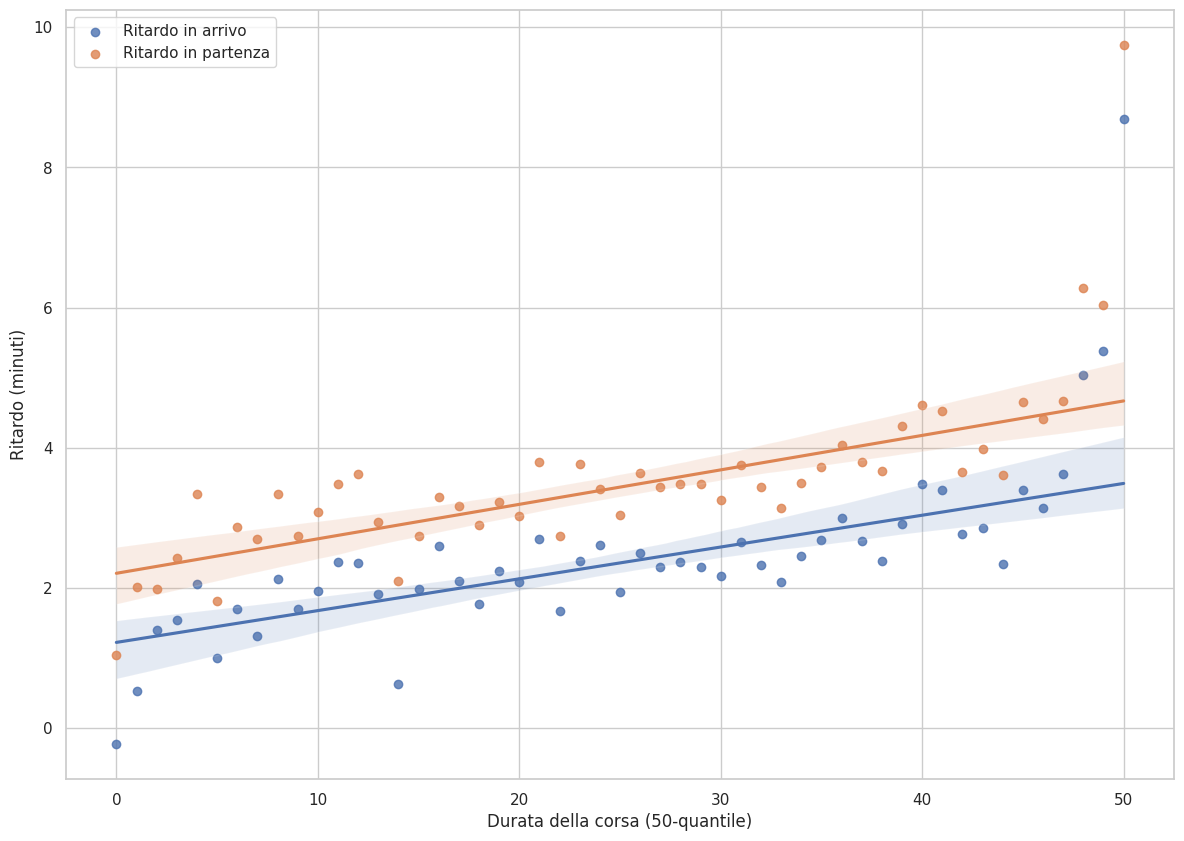

In [32]:
sns.set_theme(style="whitegrid")
ax = sns.regplot(
    category_means,
    x=category_means.index,
    y="arrival_delay",
    label="Ritardo in arrivo",
    robust=True,
)
sns.regplot(
    category_means,
    x=category_means.index,
    y="departure_delay",
    ax=ax,
    label="Ritardo in partenza",
    robust=True,
)
plt.legend()
plt.xlabel("Durata della corsa (50-quantile)")
plt.ylabel("Ritardo (minuti)")
plt.tight_layout()

plt.savefig(OUTPUT / "delay_duration_corr.pdf")
plt.show()

In [33]:
category_means.reset_index().corr()

,index,arrival_delay,departure_delay
index,1.000000,0.724199,0.736641
arrival_delay,0.724199,1.000000,0.988803
departure_delay,0.736641,0.988803,1.000000
